In [1]:
import torch

from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform

from torch.distributions import MultivariateNormal
import numpy as np
from itertools import combinations
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

from sbi.analysis import (
    conditional_corrcoeff,
    conditional_pairplot,
    conditional_potential,
    pairplot,
)

In [12]:
# Set the random seed for reproducibility
np.random.seed(42)
tel_num = 6
prior = MultivariateNormal(torch.zeros(2*tel_num), 0.5*torch.eye(2*tel_num))
prior2 = BoxUniform(low=-2 * torch.ones(2*tel_num), high=2 * torch.ones(2*tel_num))
def simulator(theta):
    gains = [theta[i] + 1j * theta[i + 1] for i in range(0, len(theta), 2)]
    pairs = list(combinations(gains, 2))
    x = [a * b for a, b in pairs]
    x = torch.tensor(x)
    return x.real+torch.randn_like(x)*0


In [13]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [14]:
inference = NPE(prior=prior2)
num_simulations = 5000
theta = prior.sample((num_simulations,))
x = simulator(theta)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 178 epochs.

In [15]:
theta_true = prior.sample((1,))
x_obs = simulator(theta_true)
print(theta_true)
print(x_obs)

tensor([[ 0.0335, -1.3888, -0.3778,  0.3105, -0.3867, -0.3670, -0.1011,  0.1402,
         -0.3955,  1.2340, -0.9049,  0.2087]])
tensor([[ 0.4186, -0.5227,  0.1913,  1.7006,  0.2595,  0.2601, -0.0053, -0.2338,
          0.2771,  0.0906,  0.6059,  0.4266, -0.1330,  0.0623,  0.1004]])


In [16]:
labels = []
for i in range(2*tel_num):
    labels.append(r'$\theta_'+str(int(i+1))+'$')
labels

['$\\theta_1$',
 '$\\theta_2$',
 '$\\theta_3$',
 '$\\theta_4$',
 '$\\theta_5$',
 '$\\theta_6$',
 '$\\theta_7$',
 '$\\theta_8$',
 '$\\theta_9$',
 '$\\theta_10$',
 '$\\theta_11$',
 '$\\theta_12$']

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 144 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 4'>, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 5'>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: xlabel='dim 6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >,

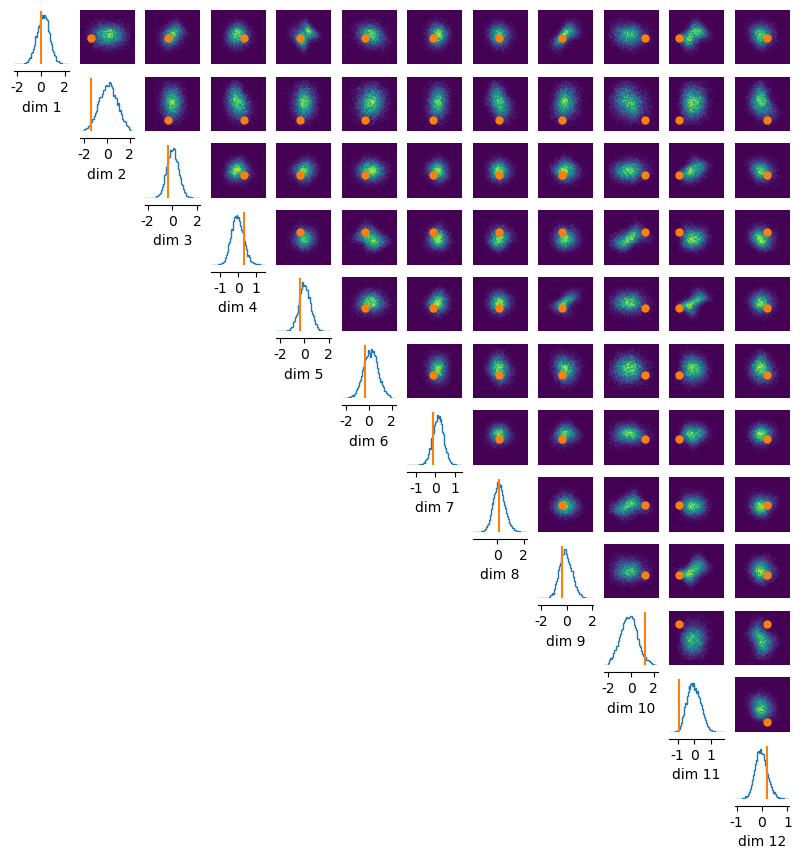

In [17]:
samples = posterior.sample((10000,), x=x_obs)
pairplot(samples,
         points=theta_true)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 144 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 4'>, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 5'>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: xlabel='dim 6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >,

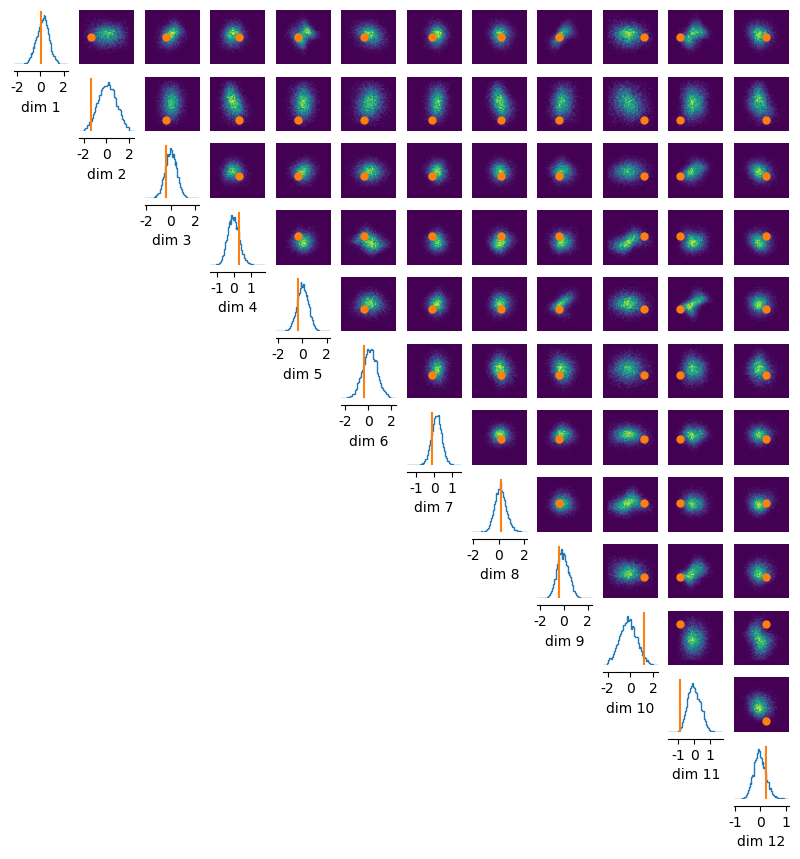

In [18]:
posterior.set_default_x(x_obs)
samples = posterior.sample((10000,))
pairplot(samples,
         points=theta_true)


(<Figure size 1000x1000 with 225 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 4'>, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 5'>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],


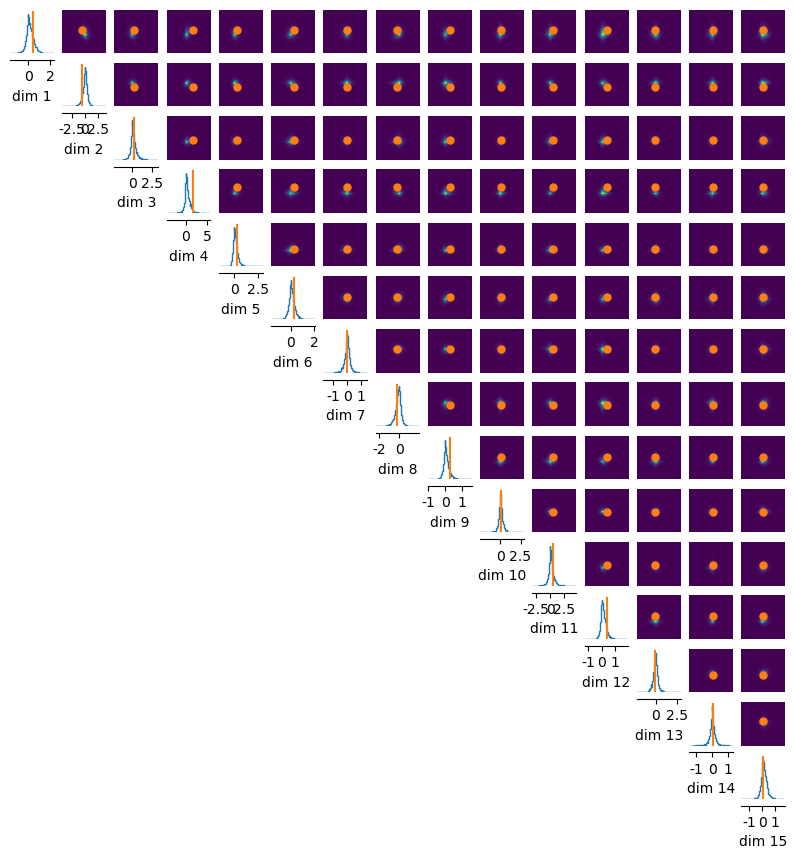

In [19]:
x_predictive = simulator(samples)  # simulate data from posterior
pairplot(x_predictive,
         points=x_obs) # 

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

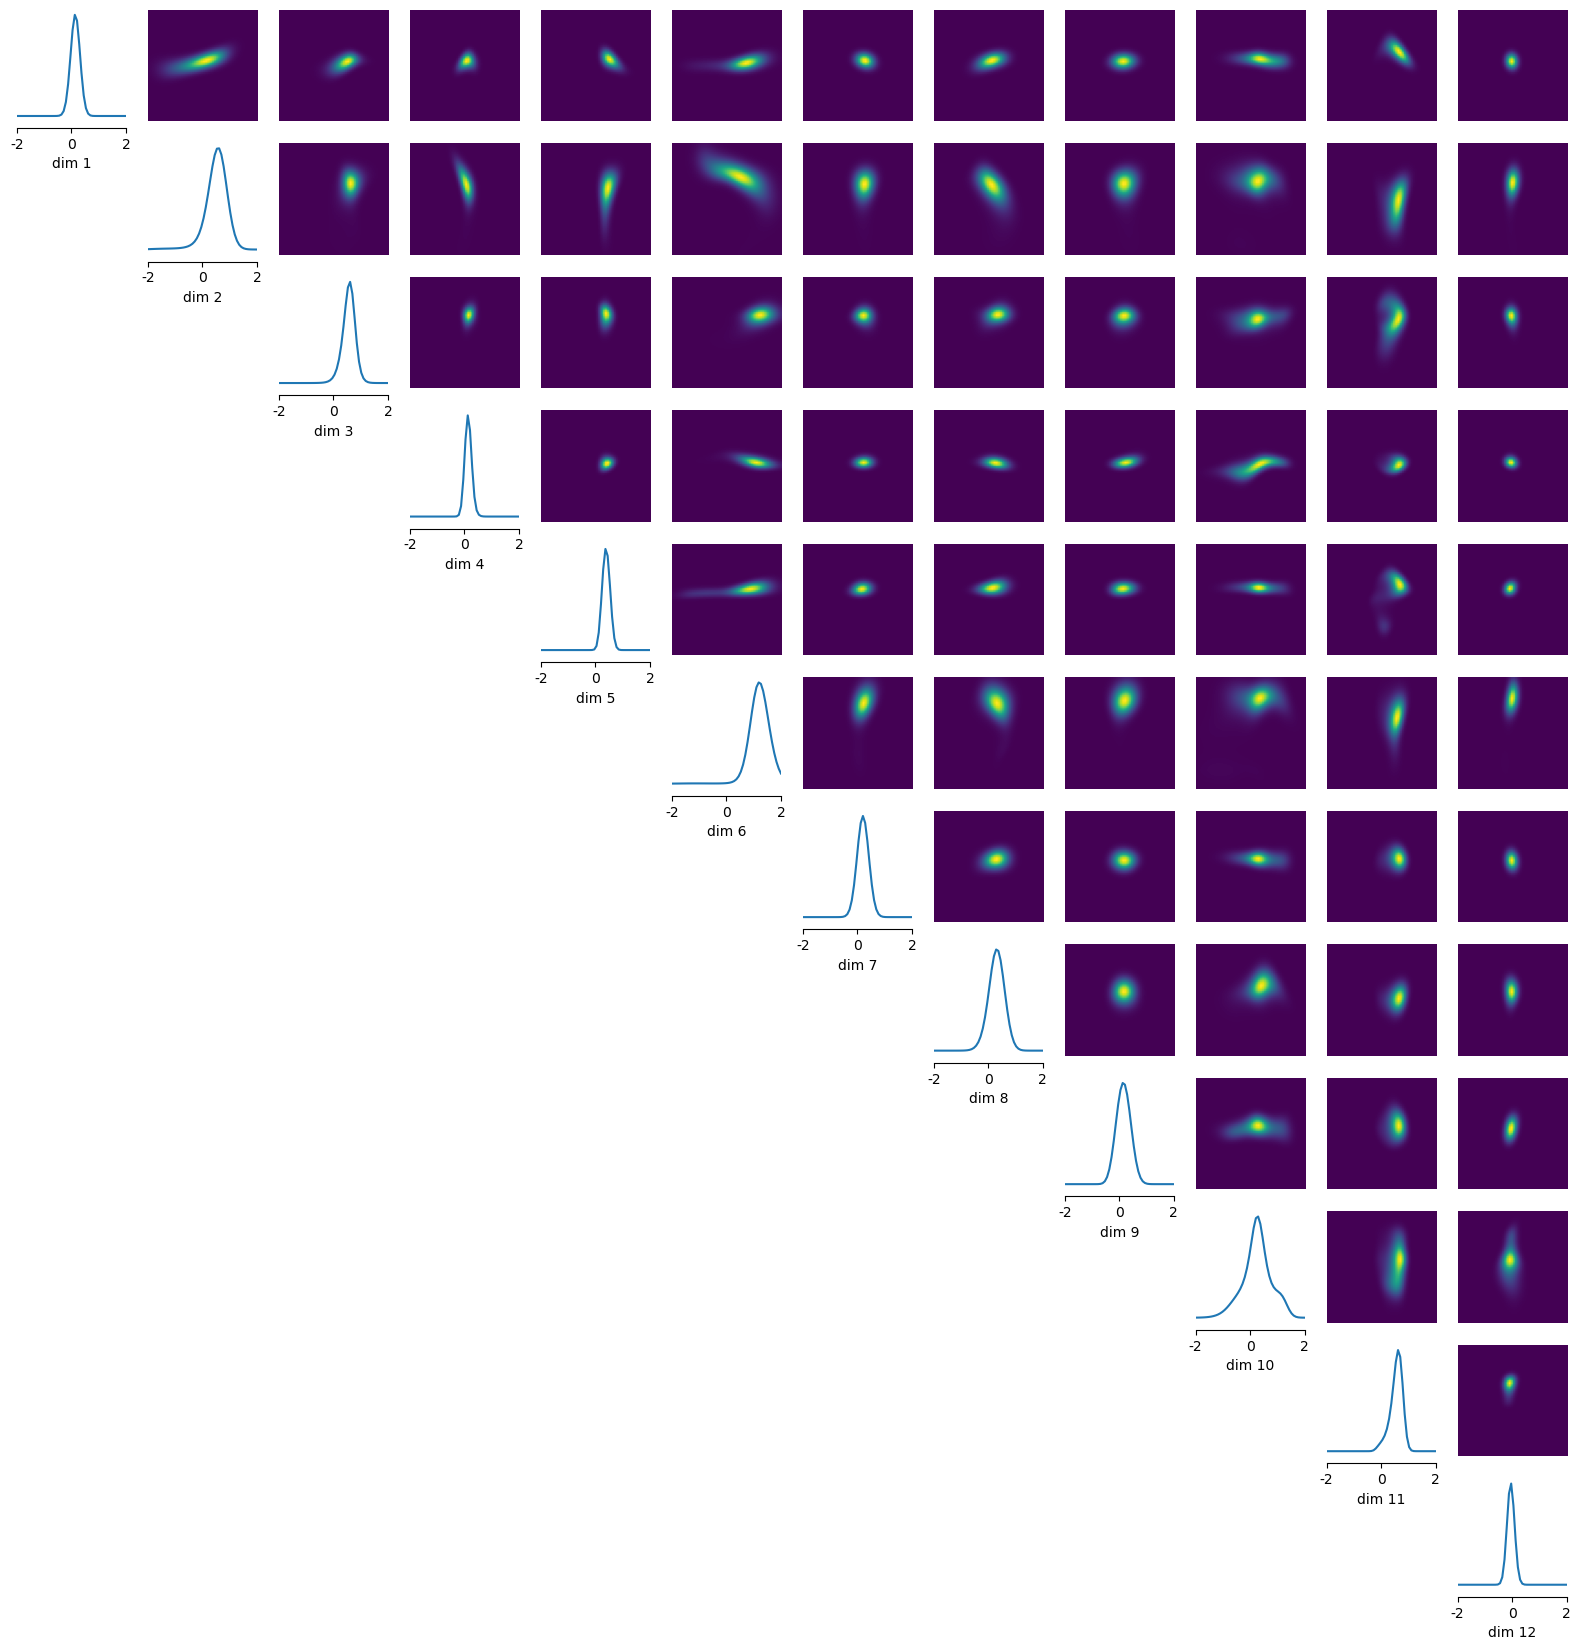

In [20]:
condition = posterior.sample((1,))

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2.0, 2.0]] * 2*tel_num),  figsize=(20, 20)
)